## Image segmentation test

In [1]:
import sys
import cv2
import time
import colorsys
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2021-08-08 12:33:10.860209: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
model = tf.keras.models.load_model('../datasets_utils/128x128unet_acc:0.9540_loss:0.0590_val-acc:0.9538_val-loss:0.0594_0.22M_01-08-21-DB_UCB300_E:10x1E-4:5x1E-5/')

2021-08-08 12:33:14.577035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-08 12:33:14.631429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-08 12:33:14.631798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX350 computeCapability: 6.1
coreClock: 1.468GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 52.21GiB/s
2021-08-08 12:33:14.631830: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-08 12:33:14.637566: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-08 12:33:14.637646: I tensorflow/stream_executor/platform

In [3]:
sys.executable

'/home/israel/repos/venvs/tf2-gpu/bin/python3'

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32, 32, 32)   4672        sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 16, 64)   18560       sequential_1[0][0]               
______________________________________________________________________________________________

In [5]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    return colors


def apply_mask(image, mask, color, alpha=0.5):
#     if image.shape[:2] != mask.shape:
#         h, w, _ = image.shape
#         mask = cv2.resize(mask, (w, h), cv2.INTER_LINEAR)
    """Apply the given mask to the image"""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def colorCast(img):
    ''' Takes a raw image as input and reduces the saturation of GREEN channel'''
    rng = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255])
    norm_rng = rng / (2000 /(1 + 5))
    exprng = np.exp(norm_rng)
    exprng = 255 * ((exprng - exprng.max()) / (exprng.max() - exprng.min()) + 1)
    # Create a LookUp Table
    fullRange = np.arange(0, 256)
    gLUT = np.interp(fullRange, rng, exprng)

    # Get the green channel and apply the mapping
    gChannel = img[:, :, 1]
    gChannel = cv2.LUT(gChannel, gLUT)
    img[:, :, 1] = gChannel
    return img

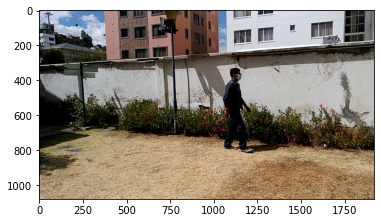

In [6]:
clip_path = '/home/israel/Downloads/OAK/j2/05.08.2021_12.42.19_id:carlos1_walk:nm/color_video.mp4'
cap = cv2.VideoCapture(clip_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 320)
ret, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [7]:
# width, height = 160, 160
width, height = 128, 128

def inference(img):
    start = time.time()
#     img = colorCast(img)
#     img = frame[50:200,230:,::-1]
    tf_image = tf.image.resize(tf.convert_to_tensor(np.array(img)),(width, height))/255
    output = model.predict(tf.expand_dims(tf_image, 0))
#     output = model.predict(tf.stack([tf_image, tf_image, tf_image, tf_image, tf_image]))
    out = np.where(output[0,:,:,0]>0.6, 1, 0)
    end = time.time()
    print(end - start)
    return out
#     plt.figure(figsize=(10,10))
#     plt.imshow(out, 'gray')
#     plt.show()

In [8]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

clip_path = '/home/israel/Downloads/OAK/j2/05.08.2021_12.42.19_id:carlos1_walk:nm/color_video.mp4'

# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
# cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-02-090.avi')
cap = cv2.VideoCapture(clip_path)

# cap = cv2.VideoCapture('/home/israel/Downloads/3.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 150)
ret, frame = cap.read()
# frame = cv2.resize(frame, (0,0), fx=0.25, fy=0.25)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
regions, _ = hog.detectMultiScale(frame, winStride=(12, 12)) 
for (x, y, w, h) in regions:
    roi = frame[y:y+h, x:x+w]
    color = random_colors(2)
    roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
    pred = inference(roi)
    out = apply_mask(roi_resized, pred, color[-1])
    plt.subplot(121); plt.imshow(roi); 
    plt.subplot(122); plt.imshow(out);
cap.release()

In [9]:
roi.shape

NameError: name 'roi' is not defined

In [45]:
def limit_bbox(x, y, w, h, width, height):
    offsets = [random.randint(0, w//2) for i in range(4)]
    x = x - offsets[0] if x - offsets[0] >=0 else 0
    y = y - offsets[1] if y - offsets[1] >=0 else 0
    w = w + offsets[2]+offsets[0] if w + offsets[2]+offsets[0] <=width else width
    h = h + offsets[3]+offsets[1] if h + offsets[3]+offsets[1] <=height else height
    return (x, y, w, h)

In [12]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

frame_height, frame_width,_ = frame.shape
out_cap = cv2.VideoWriter('CASIA_dataset.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width//4,frame_height//4))


# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
# cap = cv2.VideoCapture('/home/israel/Downloads/s1_ucb.mp4')
# cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/033-nm-02-090.avi')
# clip_path = '/home/israel/Downloads/UCB/clips/090/002/cl/cl-01.avi'
cap = cv2.VideoCapture(clip_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 250)
fw = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)//4)
fh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)//4)

roi = np.zeros((100,100))
color = random_colors(2)

cv2.namedWindow('roi', cv2.WINDOW_NORMAL)
nframe = 0
start = time.time()
fps = 30
regions = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        copied = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
#         copied = frame.copy()
        if nframe%1 == 0:
            new_regions, _ = hog.detectMultiScale(copied, winStride=(8, 8)) 
            if len(new_regions)>0:
                regions = new_regions
        for (x, y, w, h) in regions: 
#             x, y, w, h = limit_bbox(x, y, w, h, width, height)
            roi = copied[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
            if nframe%1 == 0:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                pred = inference(roi_rgb)
#             pred = lite_inference(roi)
            out = apply_mask(roi_resized, pred, color[1])
            copied[y:y+h, x:x+w] = cv2.resize(out, (w, h), cv2.INTER_LINEAR)
            cv2.rectangle(copied, (x, y), (x + w, y + h), (0, 0, 255), 2) 
            
#         cv2.imshow('test', frame)
        
        cv2.putText(copied, "fps: {:.2f}".format(fps), (5, 20), cv2.FONT_ITALIC, 0.5, (255, 0, 0))
        cv2.imshow('roi', copied)
        out_cap.write(copied)
        nframe +=1
        end = time.time()
        fps = nframe/(end - start)
    else:
        break
    if cv2.waitKey(1) == ord('q'):
        break
        
cap.release()
out_cap.release()
cv2.destroyAllWindows()

0.029654741287231445
0.0398867130279541
0.0318295955657959
0.024259090423583984
0.029442787170410156
0.02471613883972168
0.03338742256164551
0.04055380821228027
0.026086807250976562
0.027232885360717773
0.02612900733947754
0.02887725830078125
0.0475001335144043
0.02746415138244629
0.026157379150390625
0.02863335609436035
0.02740788459777832
0.03541374206542969
0.02610039710998535
0.039107322692871094
0.0285036563873291
0.026003599166870117
0.04120969772338867
0.02597188949584961
0.02545785903930664
0.026132583618164062
0.027374267578125
0.028393983840942383
0.03270745277404785
0.03168129920959473
0.029413938522338867
0.028412818908691406
0.031032323837280273
0.04107666015625
0.02750420570373535
0.025516748428344727
0.057807207107543945
0.03917360305786133
0.026389360427856445
0.029945850372314453
0.0258333683013916
0.03711581230163574
0.02711939811706543
0.026222944259643555
0.03342580795288086
0.02377462387084961
0.02926015853881836
0.024129390716552734
0.02730250358581543
0.036679506

In [62]:
cv2.destroyAllWindows()

In [50]:
width, height

(480.0, 270.0)